In [453]:
import tensorflow as tf

In [454]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

## Step 1: Load the data

In [455]:
df = pd.read_csv('./spam.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,v1.1,v2.1,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [456]:
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [457]:
print(set(df.v1))

{'spam', 'ham', 'ham"""'}


In [458]:
for i in range(len(df)):
    if df.v1[i] == 'ham"""':
        df.v1[i] = 'ham'    

In [459]:
print(set(df.v1))

{'spam', 'ham'}


In [460]:
for i in range(len(df)):
    if type(df.v2[i]) != str:
        df.v2[i] = " "

In [461]:
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [462]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [463]:
Y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [464]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

## Step 2:  Build the model

In [465]:
df_train = np.array(df_train)
df_test = np.array(df_test)
print(df_train.shape)

(3735,)


Maximum number of vocabulary:  we set it 20000

tokenizer parse the sentence.  For example, 

"I like apples" => "I", "like", "apples"

Then we change this to integer valued vector. $[1,2,3]$

In [466]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test) #<- output is a list 
# this is in the form of [[1,2,3,4,5], [2,3,4], .... , [1,3,4,5]]
print('sequences_train type is', type(sequences_train))

sequences_train type is <class 'list'>


$V$ is the number of unique words

In [467]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokes.' % V)

Found 7173 unique tokes.


In [468]:
data_train = pad_sequences(sequences_train) # <- output is numpy array
print('Shape of data train tensor:', data_train.shape)
print('data_train type is', type(data_train))

T = data_train.shape[1]
print(T)

Shape of data train tensor: (3735, 162)
data_train type is <class 'numpy.ndarray'>
162


In [469]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1841, 162)


In [470]:
# Create the model

# We get to choose embedding dimensionality <- the maximum number of words in a sentence or could be more or less by padding or truncating
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

## Step 3: Train

In [471]:
# Compile and fit
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=20,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/20
117/117 [==============================] - 5s 45ms/step - loss: 0.4849 - accuracy: 0.8503 - val_loss: 0.3533 - val_accuracy: 0.8691
Epoch 2/20
117/117 [==============================] - 5s 40ms/step - loss: 0.3166 - accuracy: 0.8645 - val_loss: 0.2613 - val_accuracy: 0.8691
Epoch 3/20
117/117 [==============================] - 5s 41ms/step - loss: 0.2193 - accuracy: 0.8645 - val_loss: 0.1900 - val_accuracy: 0.8691
Epoch 4/20
117/117 [==============================] - 5s 41ms/step - loss: 0.1447 - accuracy: 0.9722 - val_loss: 0.1288 - val_accuracy: 0.9832
Epoch 5/20
117/117 [==============================] - 5s 41ms/step - loss: 0.0907 - accuracy: 0.9949 - val_loss: 0.0970 - val_accuracy: 0.9837
Epoch 6/20
117/117 [==============================] - 5s 41ms/step - loss: 0.0598 - accuracy: 0.9968 - val_loss: 0.0732 - val_accuracy: 0.9870
Epoch 7/20
117/117 [==============================] - 5s 41ms/step - loss: 0.0404 - accuracy: 0.9979 - val_loss: 0.0610 - va

# Step 4: Evaluate

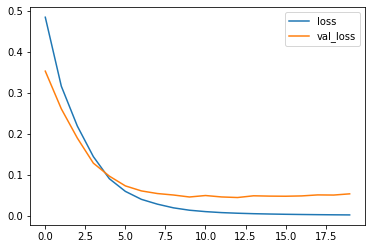

In [472]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

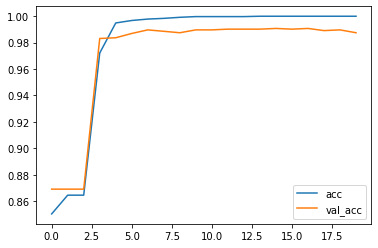

In [473]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [474]:
prediction = model.predict(data_test)
prediction = np.rint(prediction)
prediction = prediction.astype(int)
prediction.reshape(-1)

array([0, 1, 0, ..., 0, 0, 0])

In [475]:
Ytest = Ytest.astype(int)

In [476]:
l = []
for i in range(len(Ytest)):
    if prediction[i] != Ytest[i]:
        l.append(i)

In [477]:
for i in range(10):
    random_number = np.random.choice(l)
    print(df_test[random_number])
    print("it is predicted:",prediction[random_number][0], "but actually it is", Ytest[random_number])
    print("")

Missed call alert. These numbers called but left no message. 07008009200
it is predicted: 0 but actually it is 1

Back 2 work 2morro half term over! Can U C me 2nite 4 some sexy passion B4 I have 2 go back? Chat NOW 09099726481 Luv DENA Calls å£1/minMobsmoreLKPOBOX177HP51FL
it is predicted: 0 but actually it is 1

naughty little thought: 'its better to flirt, flirt n flirt, rather than loving someone n gettin hurt, hurt n hurt...:-) Gud nyt
it is predicted: 1 but actually it is 0

CLAIRE here am havin borin time & am now alone U wanna cum over 2nite? Chat now 09099725823 hope 2 C U Luv CLAIRE xx Callså£1/minmoremobsEMSPOBox45PO139WA
it is predicted: 0 but actually it is 1

Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry scores with a simple shot from 6 yards from a pass by Bergkamp to give Arsenal a 2 goal margin after 78 mins.
it is predicted: 0 but actually it is 1

Missed call alert. These numbers called but left no message. 07008009200
it is predicted: 0 but actually it is 1

Sorry I

## Step 5: Predict

In [478]:
X = ["Sales begin on Friday!! Enjoy shopping"]
X = np.array(X)

In [479]:
tokenizer.fit_on_texts(X)
random_sentence = tokenizer.texts_to_sequences(X)
random_test = pad_sequences(random_sentence, maxlen=T)

In [480]:
if model.predict(random_test) < 0.5:
    print("The message", X, "is not a spam")
else: 
    print("The message", X, "is a spam")

The message ['Sales begin on Friday!! Enjoy shopping'] is not a spam
